# Credits
<!-- Credits for the source code go to [Oscar Leo](https://github.com/oscarleoo) -->
Credits for the source code go to [@oscarleoo](https://github.com/oscarleoo).
- Polar plot tutorial by Oscar Leo: [How to Create a Polar Histogram with Python and Matplotlib](https://towardsdatascience.com/how-to-create-a-polar-histogram-with-python-and-matplotlib-9e266c22c0fa)
- GitHub repository with the tutorial code: [oscarleoo/polar-histogram-tutorial](https://github.com/oscarleoo/polar-histogram-tutorial)

Below code is based on source code but a different dataset and adjustments are made for ease of use/modularity.

# DEPENDENCIES

In [582]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.lines import Line2D
from matplotlib.patches import Wedge
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# LOAD DATA

In [659]:
# Make sure the file path is correct
file_path = "imf-dm-export-20230827.csv"

# Try different encodings until you find the one that works
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv(file_path, encoding=encoding, skiprows=[1])
        # If successful, break out of the loop
        print(f"Success with encoding: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"Failed with encoding: {encoding}")

Failed with encoding: utf-8
Success with encoding: latin1


# PREPROCESS IMF DATA
source: https://www.imf.org/external/datamapper/CG_DEBT_GDP@GDD/CHN/FRA/DEU/ITA/JPN/GBR/USA

In [584]:
# TEST
df.head()

,Central Government Debt (Percent of GDP),1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,6.759467879,6.904479171,8.70029105,9.154082857,8.437266097,7.997660199,7.384412942,6.130409903,7.39749473,no data
1,Albania,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,62.11995289,65.53000174,70.03000162,72.670076,72.38004424,70.11993217,67.61001652,65.72986791,74.44966943,73.16706592
2,Algeria,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,9.325658289,7.093511132,7.658320146,8.733313712,20.43828686,26.80830309,38.25615076,46.04436616,52.2727002,62.98681354
3,Angola,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,26.69055968,33.14910364,39.80985691,57.09304822,75.66263732,69.32286758,92.99500121,113.5541748,136.5401246,86.41135998
4,Antigua and Barbuda,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,87.49408921,95.79104783,101.369132,99.07128775,86.12589358,92.19273211,87.69958735,81.25083661,101.4769561,101.3730034


In [585]:
# Select specific columns and rename them
df = df.iloc[:, [0, -1]]

df.columns = ['country', 'score']

# List of countries to exclude
exclude_countries = [
    "Brunei Darussalam", "Tuvalu", "Timor-Leste", "Solomon Islands", "Kiribati", "Haiti", 
    "Saint Kitts and Nevis", "Taiwan Province of China", "Türkiye, Republic of", 
    "Equatorial Guinea", "Guyana", "Czech Republic", "Korea, Republic of", "Djibouti", 
    "Samoa", "Tonga", "Central African Republic", "Vanuatu", "West Bank and Gaza", 
    "Papua New Guinea", "North Macedonia", "Côte d'Ivoire", "Qatar", "Trinidad and Tobago", 
    "Kyrgyz Republic", "Oman", "South Sudan, Republic of", "Burundi", "Slovak Republic", 
    "Grenada", "São Tomé and Príncipe", "Seychelles", "Guinea-Bissau", "Belize", 
    "Gambia, The", "Fiji", "Angola", "San Marino", "Bahamas, The", "Lao P.D.R.", 
    "Saint Lucia", "Antigua and Barbuda", "Congo, Republic of", "Dominica", "Maldives", 
    "Suriname", "Bhutan", "Barbados", "Cabo Verde", "Eritrea", "Sudan"
]

# Filter out excluded countries
df = df[~df['country'].isin(exclude_countries)]


df = df.sort_values("score").reset_index(drop=True)

df

,country,score
0,United Kingdom,102.9726972
1,Sri Lanka,103.0792997
2,"Congo, Republic of",103.6393958
3,Spain,106.2164816
4,Mozambique,106.3686291
...,...,...
122,Saint Vincent and the Grenadines,no data
123,Ecuador,no data
124,Afghanistan,no data
125,NaN,NaN


In [586]:
# Select specific columns and rename them
df = df.iloc[:, [0, -1]]
df.columns = ['country', 'score']  # Rename '% of gdp' to 'score'

# Remove rows with NaN values in the 'country' column
df = df.dropna(subset=['country'])

# Remove row with '©IMF, 2023' in the 'country' column
df = df[df['country'] != '©IMF, 2023']

# Replace 'no data' with NaN
df['score'] = df['score'].replace('no data', pd.NA)

# Convert 'score' column to numeric
df['score'] = pd.to_numeric(df['score'], errors='coerce')

# Round 'score' values to 2 decimal places
df['score'] = df['score'].round(2)

# Define custom bins and labels for the 'label' column
bins = [-float('inf'), 30, 60, 90, float('inf')]  # Adjust ranges as needed
labels = ['Low', 'Moderate', 'High', 'Very High']

# Feature engineering: Create the 'label' column based on 'score' values
df['label'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)

# Add the 'Unknown' category to the 'label' column
df['label'] = df['label'].cat.add_categories(['Unknown'])

# Fill NaN values in the 'label' column with the 'Unknown' label
df['label'].fillna('Unknown', inplace=True)

df = df.dropna(subset=['score'])

df = df.sort_values('score', ascending=True).reset_index(drop=True)

In [587]:
# save df to a csv file
#df.to_csv('my_df_govdebtperc.csv', index=False)

# SET FONT

In [588]:
#font_family = "PT Mono"
font_family = "Calibri"
background_color = "#000000"
text_color = "#FFFFFF"
#custom_colors = ["#009688", "#4CAF50", "#FFC107", "#FF5722", "#607D8B"]  # Custom colors for different debt levels
#custom_colors = ['#900C3F', '#C70039', '#F94C10', '#F8DE22']
custom_colors = ["#6F61C0", "#A084E8", "#8BE8E5", "#D5FFE4"]
legend_background_color = "#FFFFFF"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

# SET GLOBALS

In [657]:
START_ANGLE = 80 # At what angle to start drawing the first wedge
END_ANGLE = 430 # At what angle to finish drawing the last wedge
SIZE = (END_ANGLE - START_ANGLE) / len(df) # The size of each wedge
PAD = 0.5 * SIZE # The padding between wedges

INNER_PADDING = 30
#INNER_PADDING = 2 * df.score.min() # 

LIMIT = (INNER_PADDING + df.score.max()) * 1.3 # Limit of the axes

# FUNCTIONS

In [590]:
def draw_wedge(ax, start, end, length, width, color):
    ax.add_artist(Wedge((0, 0), length, start, end, color=color, width=width))

In [591]:
def color(income_group=""):
    if income_group == "Very High":
        return custom_colors[0]
    elif income_group == "High":
        return custom_colors[1]
    elif income_group == "Moderate":
        return custom_colors[2]
    elif income_group == "Low":
        return custom_colors[3]
    else:
        return custom_colors[4]

In [592]:
def add_text(ax, x, y, country, score, angle):
    if angle < 270:
        text = "{} ({})".format(country, score)
        ax.text(x, y, text, fontsize=13, rotation=angle-180, ha="right", va="center", rotation_mode="anchor")
    else:
        text = "({}) {}".format(score, country)
        ax.text(x, y, text, fontsize=13, rotation=angle, ha="left", va="center", rotation_mode="anchor")

In [593]:
def add_flag(ax, x, y, name, zoom, rotation):
    flag = Image.open("../../data/country-flags/png/{}.png".format(name.lower()))
    flag = flag.rotate(rotation if rotation > 270 else rotation - 180)
    im = OffsetImage(flag, zoom=zoom, interpolation="lanczos", resample=True, visible=True)

    ax.add_artist(AnnotationBbox(
        im, (x, y), frameon=False,
        xycoords="data",
    ))

In [650]:
# def add_legend(labels, colors, title, custom_colors):
#     lines = [Line2D([], [], marker='o', markersize=24, linewidth=0, color=c) for c in colors]

#     plt.legend(
#         lines, labels,
#         fontsize=18, loc="upper left", alignment="left", borderpad=1.3, edgecolor=custom_colors[0], labelspacing=1,
#         facecolor="#000000", framealpha=1, borderaxespad=1,
#         title=title,
#         title_fontsize=20,
#     )


def add_legend(labels, colors, title, custom_colors):
    lines = [Line2D([], [], marker='o', markersize=24, linewidth=0, color=c) for c in colors]

    plt.legend(
        lines, labels,
        fontsize=18, loc="upper left", alignment="left", borderpad=1.3, edgecolor=custom_colors[3], labelspacing=1,
        facecolor="#000000", framealpha=1, borderaxespad=1,
        title=title,
        title_fontsize=20,
        bbox_to_anchor=(0.7, 0.9),  # Adjust these values to move the legend
    )

In [630]:
def draw_reference_line(ax, point, size, padding, fontsize=18):
    draw_wedge(ax, 0, 360, point+padding+size/2, size, background_color)
    ax.text(-0.7, padding + point, f"{point}%", va="center", rotation=1, fontsize=fontsize, color=custom_colors[3])

In [631]:
def get_xy_with_padding(length, angle, padding):
    x = math.cos(math.radians(angle)) * (length + padding)
    y = math.sin(math.radians(angle)) * (length + padding)
    return x, y

# POLAR PLOT

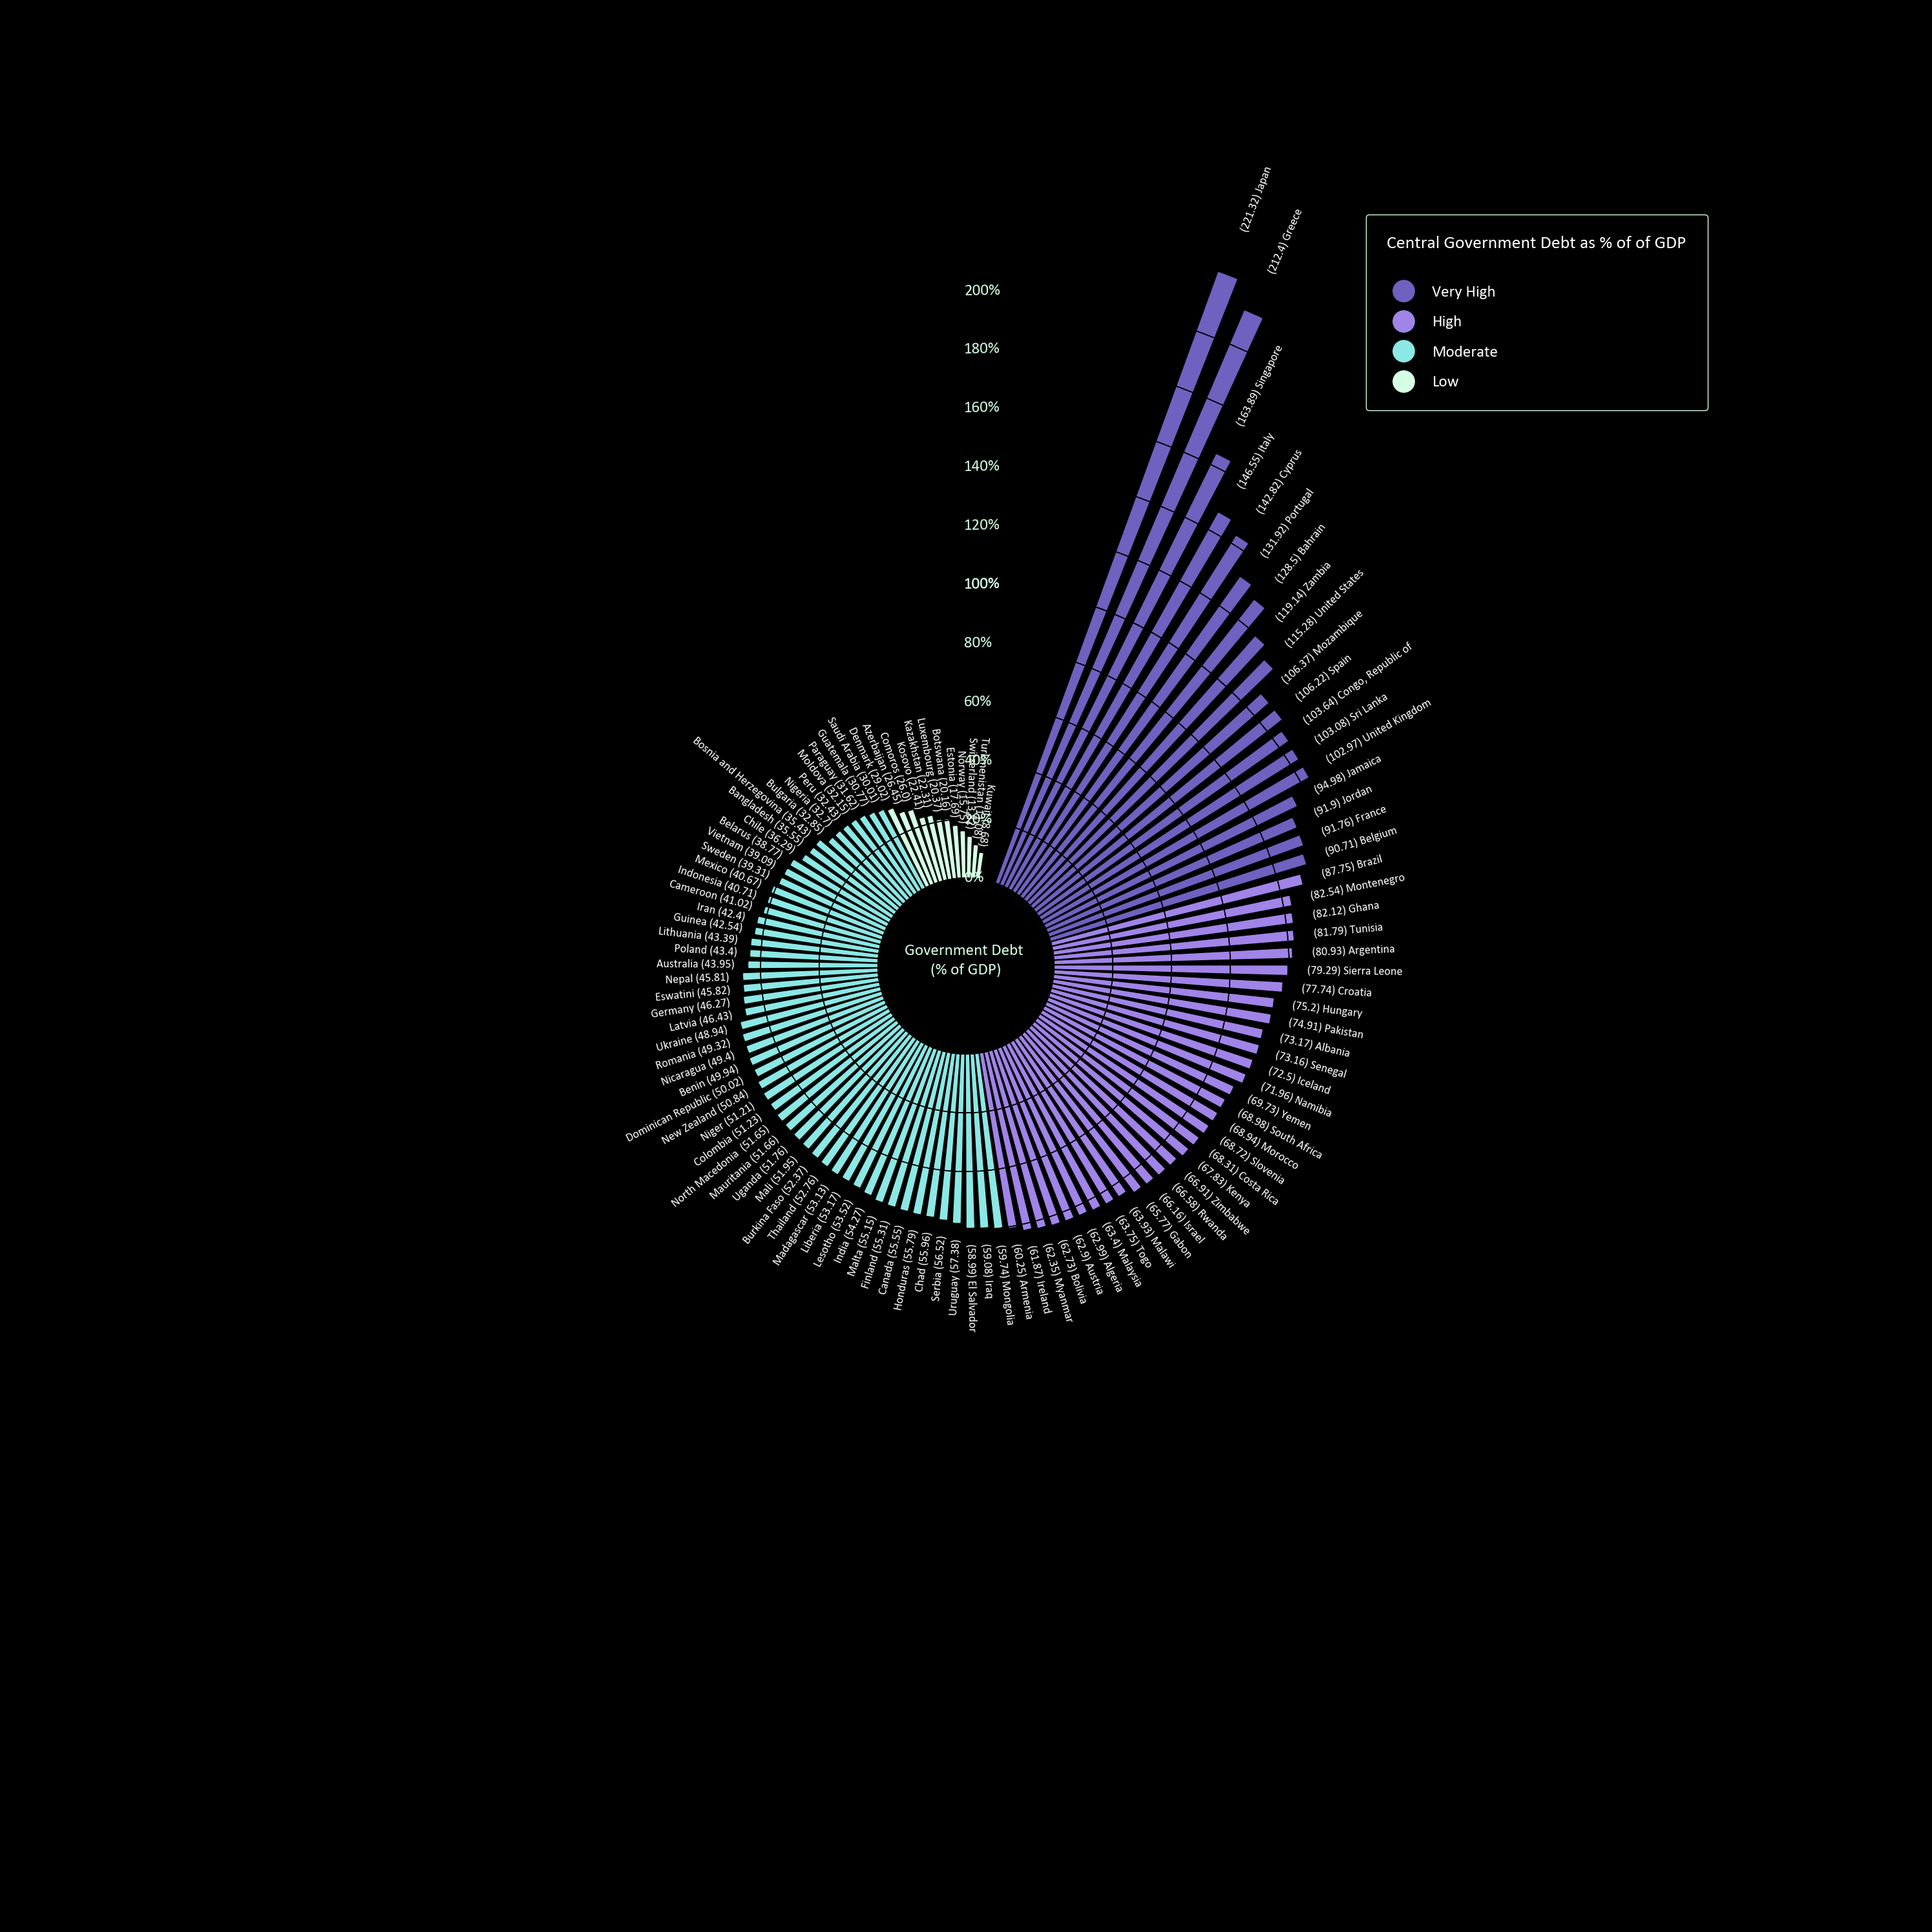

In [658]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))
ax.set(xlim=(-LIMIT, LIMIT), ylim=(-LIMIT, LIMIT))

for i, row in df.iterrows():
    bar_length = row.score
    length = bar_length + INNER_PADDING
    start = START_ANGLE + i*SIZE + PAD
    end = START_ANGLE + (i+1)*SIZE
    angle = (end + start) / 2
    
    # Add variables here
    flag_zoom = 0.004 * length
    flag_x, flag_y = get_xy_with_padding(length, angle, 8*flag_zoom)
    text_x, text_y = get_xy_with_padding(length, angle, 16*flag_zoom)
    
    # Add functions here
    draw_wedge(ax, start, end, length, bar_length, color(row.label))
    #add_flag(ax, flag_x, flag_y, row.country, flag_zoom, angle)
    add_text(ax, text_x, text_y, row.country, bar_length, angle)


# Add general functions here
draw_reference_line(ax, 0, 0.06, INNER_PADDING)
draw_reference_line(ax, 20, 0.06, INNER_PADDING)
draw_reference_line(ax, 40, 0.06, INNER_PADDING)
draw_reference_line(ax, 60, 0.06, INNER_PADDING)
draw_reference_line(ax, 80, 0.06, INNER_PADDING)
draw_reference_line(ax, 100, 0.06, INNER_PADDING)
draw_reference_line(ax, 100, 0.06, INNER_PADDING)
draw_reference_line(ax, 120, 0.06, INNER_PADDING)
draw_reference_line(ax, 140, 0.06, INNER_PADDING)
draw_reference_line(ax, 160, 0.06, INNER_PADDING)
draw_reference_line(ax, 180, 0.06, INNER_PADDING)
draw_reference_line(ax, 200, 0.06, INNER_PADDING)

plt.title("Government Debt \n(% of GDP)", x=0.5, y=0.5, va="center", ha="center", fontsize=18, linespacing=1.5, color=custom_colors[3])

add_legend(
    labels=["Very High", "High", "Moderate", "Low", "Unknown"],
    colors=custom_colors,
    title="Central Government Debt as % of of GDP\n",
    custom_colors = custom_colors
)

# Save the plot as a PNG image
#plt.savefig("government_debt_plot.png", dpi=300)  # Change the filename and dpi as needed

plt.axis("off")
plt.tight_layout()
plt.show()